<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="assets/dh.png" 
               style="width:500px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>06. Model - LightGBM</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Métrica para optimización de hiperparámetros](#22)<br>
    2.3. [Lectura de datos](#23)<br>
    2.4. [Separación en train y test](#24)<br>
    2.5. [Target encoding](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Pipeline preprocesamiento datos categóricos nominales](#31)<br>
    3.2. [Pipeline preprocesamiento datos categóricos ordinales y datos numéricos](#32)<br>
    3.3. [Unión de pipeline preprocesamiento](#33)<br>
    3.4. [Pipeline modelo](#34)<br>
    3.5. [Optimizacion de hiperparametros](#35)<br>
    3.6. [Visualizaciones de hiperparámetros](#36)<br>
    3.7. [Entrenamiento del modelo con mejores hiperparámetros](#37)<br>
    3.8. [Seteado de threshold óptimo](#38)<br>
4. [Evaluación del modelo](#4)<br>
    4.1. [Cálculo de métricas](#41)<br>
    4.2. [Matriz de confusión](#42)<br>
    4.3. [ROC Curve](#43)<br>
    4.4. [Precision-Recall Curve](#44)<br>
    4.5. [Feature importance](#45)<br>
5. [Exportación con shelve](#5)<br>
    5.1. [Exportación con shelve](#51)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `aug.csv` | datos relacionados a cada alumno que aprobo un curso |`.../archive/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo Shelve con:** 
1. Modelo entrenado Light GBM
2. Variable Threshold optimo de trabajo del modelo
3. DataFrame con valores de funcion de costo 
4. DataFrame con valores de metricas del modelo

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib. pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, accuracy_score, roc_auc_score, recall_score, fbeta_score, make_scorer, f1_score, roc_curve, precision_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,  FunctionTransformer, LabelEncoder, binarize
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn import tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
import lightgbm as lgb

import optuna

from IPython.display import Image
import pydotplus

import shelve

import warnings
warnings.filterwarnings("ignore")

C:\Users\gtoso\anaconda3\envs\dhproyect\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Esta clase permite aislar columnas de un DataFrame dentro de un pipeline

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [3]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="22"></a> <br>
### 2.2. Métrica para optimización de hiperparámetros
**F2 Score**

In [4]:
# Creacion de score f2 
ftwo_scorer = make_scorer(fbeta_score, beta=2)

<a id="23"></a> <br>
### 2.3. Lectura de datos

In [5]:
# Se importa el dataframe
key = "aug.csv"
path = "../archive/"

df= pd.read_csv (path + key)

<a id="24"></a> <br>
### 2.4. Separación en train y test

In [6]:
# Selección de variable targuet
y = df.target
# Selección de features
X = df.drop(["target"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 161, stratify= y)

# Verificación de distribución de variable targuet en train y test
print("Distribución de variable target en Train \n", y_train.value_counts(normalize=True))
print("========================================")
print("Distribución de variable target en Test \n", y_test.value_counts(normalize=True))

Distribución de variable target en Train 
 0.0    0.75062
1.0    0.24938
Name: target, dtype: float64
Distribución de variable target en Test 
 0.0    0.750783
1.0    0.249217
Name: target, dtype: float64


<a id="25"></a> <br>
### 2.5. Target encoding

In [7]:
# Transformación de variable targuet categórica en numérica
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Pipeline preprocesamiento datos categóricos nominales

In [8]:
# Pipeline preprocesamiento data categórica nominal

pasos_nominal_pipe = [("ColumnSelector", ColumnSelector(["gender", "major_discipline", "company_type", "city"])),
                                  
                       ("SimpleImputer", SimpleImputer( strategy = "most_frequent")),
                                          
                       ("OneHotEncoder", OneHotEncoder(sparse = False, min_frequency= 50, handle_unknown = "infrequent_if_exist"))]
                                  
pipe_nominal = Pipeline(pasos_nominal_pipe)

<a id="32"></a> <br>
### 3.2. Pipeline preprocesamiento datos categóricos ordinales y datos numéricos

In [9]:
# Listas de categorías de datos categóricos ordinales

relevent_experience = [ "No relevent experience", "Has relevent experience"]
enrolled_university = ["no_enrollment", "Part time course", "Full time course"]
education_level = ["Primary School", "High School", "Graduate",  "Masters", "Phd"]
experience = ["<1", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", ">20"]
company_size = ["<10", "10/49", "50-99", "100-500", "500-999", "1000-4999", "5000-9999", "10000+"]
last_new_job = ["never", "1", "2", "3", "4", ">4"]

# Creación de lista con categorías de datos categóricos ordinales

categories = [relevent_experience, enrolled_university, education_level, experience, company_size, last_new_job]

In [10]:
# Pipeline preprocesamiento datos categóricos ordinales y numéricos

pasos_ordinal_numerical_pipe = [("column_transformer",ColumnTransformer([
                                         ("ordinal_encoder", OrdinalEncoder( categories = categories, handle_unknown =  "use_encoded_value", unknown_value= np.nan),   
                    ["relevent_experience", "enrolled_university", "education_level", "experience", "company_size", "last_new_job"]),
                                        ("standard_scaler", StandardScaler(), 
                    ["city_development_index", "training_hours"])])),
                                 
                                 ("knn_imputer", KNNImputer(n_neighbors = 10))]

# Creación del pipeline de preprocesamiento de datos ordinaales y numéricos

pipe_ordinal_and_numerical = Pipeline(pasos_ordinal_numerical_pipe)

<a id="33"></a> <br>
### 3.3. Unión de pipeline preprocesamiento 

In [11]:
# Pipeline unión de pipe_nominal y pipe_ordinal
pipe_preprocesamiento = make_union (pipe_nominal,
                                   pipe_ordinal_and_numerical)


<a id="34"></a> <br>
### 3.4. Pipeline modelo

In [12]:
# Pipeline modelo
light_gbm = lgb.LGBMClassifier(random_state = 45)

pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["enrollee_id"])),
                       ("pipe_preprocesamiento", pipe_preprocesamiento),
                        ("smote", SMOTE(random_state = 45)),
                      ("lgbm", light_gbm)])

<a id="35"></a> <br>
### 3.5. Optimización de hiperparámetros

In [41]:
# Función objetivo de optuna

def objective_pipe(trial):
    
    #=============================================================================================================#
    # Pipeline preprocesamiento data categórica nominal
    
    # Pasos del pipeline nominal
    pasos_nominal_pipe = [("ColumnSelector", ColumnSelector(["gender", "major_discipline", "company_type", "city"])),
                               ("SimpleImputer", SimpleImputer( strategy = "most_frequent")),
                               ("OneHotEncoder", OneHotEncoder(sparse = False, min_frequency= 50, handle_unknown = "infrequent_if_exist"))]
    # Pipeline nominal
    pipe_nominal = Pipeline(pasos_nominal_pipe) # pipeline nominal
    #=============================================================================================================#
    # Pipeline preprocesamiento data categoricos ordinales y numericos
    
    # Categorias para datos categóricos ordinales
    relevent_experience = [ "No relevent experience", "Has relevent experience"]
    enrolled_university = ["no_enrollment", "Part time course", "Full time course"]
    education_level = ["Primary School", "High School", "Graduate",  "Masters", "Phd"]
    experience = ["<1", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", ">20"]
    company_size = ["<10", "10/49", "50-99", "100-500", "500-999", "1000-4999", "5000-9999", "10000+"]
    last_new_job = ["never", "1", "2", "3", "4", ">4"]
    categories = [relevent_experience, enrolled_university, education_level, experience, company_size, last_new_job]
    
    # Hiperparametros de pipe ordinal and numerical
    n_neighbors_knn_imputer = trial.suggest_int("n_neighbors_knn_imputer", 5, 200) # knn_imputer
   

    pasos_ordinal_numerical_pipe = [("column_transformer",ColumnTransformer([
                                                     ("ordinal_encoder", OrdinalEncoder( categories = categories, handle_unknown =  "use_encoded_value", unknown_value= np.nan),   
                                ["relevent_experience", "enrolled_university", "education_level", "experience", "company_size", "last_new_job"]),
                                                    ("standard_scaler", StandardScaler(), 
                                ["city_development_index", "training_hours"])])),
                                          
                                    ("knn_imputer", KNNImputer(n_neighbors = n_neighbors_knn_imputer))]
    # Pipeline ordinal and numerical
    pipe_ordinal_and_numerical = Pipeline(pasos_ordinal_numerical_pipe) # pipeline ordinal and numerical
    #===============================================================================================================#
    # Pipeline preprocesamiento
   
    pipe_preprocesamiento = make_union (pipe_nominal, pipe_ordinal_and_numerical)
    #===============================================================================================================#
    # Pipeline modelo
    
    # Hiperparametros del pipe 
    k_neighbors_smote = trial.suggest_int("k_neighbors_smote", 5, 200)  # smote
    sampling_strategy_smote = trial.suggest_categorical ("sampling_strategy_smote", ["minority", 'not majority', 'all']) # smote
    
    max_depth_lgbm = trial.suggest_int("max_depth_lgbm", 5, 50) # lgbm
    learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm", 0.001, 0.08) # lgbm
    n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm", 5, 100) # lgbm
    
    
    
    # Pipeline del modelo

    # Pipeline modelo
    light_gbm = lgb.LGBMClassifier(random_state = 45, max_depth = max_depth_lgbm, learning_rate = learning_rate_lgbm,
                                  n_estimators = n_estimators_lgbm)

    pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["enrollee_id"])),
                           ("pipe_preprocesamiento", pipe_preprocesamiento),
                            ("smote", SMOTE(random_state = 45)),
                          ("lgbm", light_gbm)])
    
    # Cross validation
    kfold=StratifiedKFold(n_splits=3, random_state=1,shuffle=True)    
    
    # Return
    return cross_val_score(pipe, X_train, y_train, cv=kfold, scoring=ftwo_scorer).mean()

In [42]:
%%time
models=[]
scores=[]
pipe_study = optuna.create_study(direction='maximize')
pipe_study.optimize(objective_pipe, n_trials=30)
model='light_gbm'
score=pipe_study.best_trial.value
models.append(model)
scores.append(score)

[I 2022-09-19 18:14:57,488] A new study created in memory with name: no-name-889f139e-794b-4299-9463-f030ad77f611
[I 2022-09-19 18:15:09,969] Trial 0 finished with value: 0.6536993944332389 and parameters: {'n_neighbors_knn_imputer': 19, 'k_neighbors_smote': 47, 'sampling_strategy_smote': 'not majority', 'max_depth_lgbm': 70, 'learning_rate_lgbm': 0.01674686581769023, 'n_estimators_lgbm': 6}. Best is trial 0 with value: 0.6536993944332389.
[I 2022-09-19 18:15:22,864] Trial 1 finished with value: 0.6283456576239191 and parameters: {'n_neighbors_knn_imputer': 87, 'k_neighbors_smote': 11, 'sampling_strategy_smote': 'minority', 'max_depth_lgbm': 60, 'learning_rate_lgbm': 0.06377464225073161, 'n_estimators_lgbm': 84}. Best is trial 0 with value: 0.6536993944332389.
[I 2022-09-19 18:15:35,200] Trial 2 finished with value: 0.659674701573513 and parameters: {'n_neighbors_knn_imputer': 63, 'k_neighbors_smote': 89, 'sampling_strategy_smote': 'minority', 'max_depth_lgbm': 11, 'learning_rate_lgbm'

[I 2022-09-19 18:19:48,803] Trial 24 finished with value: 0.6652850513008916 and parameters: {'n_neighbors_knn_imputer': 59, 'k_neighbors_smote': 83, 'sampling_strategy_smote': 'all', 'max_depth_lgbm': 42, 'learning_rate_lgbm': 0.019787594211619797, 'n_estimators_lgbm': 14}. Best is trial 12 with value: 0.6688965906930718.
[I 2022-09-19 18:20:00,646] Trial 25 finished with value: 0.6616504306892076 and parameters: {'n_neighbors_knn_imputer': 58, 'k_neighbors_smote': 85, 'sampling_strategy_smote': 'not majority', 'max_depth_lgbm': 45, 'learning_rate_lgbm': 0.01980061883416979, 'n_estimators_lgbm': 14}. Best is trial 12 with value: 0.6688965906930718.
[I 2022-09-19 18:20:12,026] Trial 26 finished with value: 0.661591146258878 and parameters: {'n_neighbors_knn_imputer': 47, 'k_neighbors_smote': 74, 'sampling_strategy_smote': 'all', 'max_depth_lgbm': 37, 'learning_rate_lgbm': 0.03380486617226357, 'n_estimators_lgbm': 12}. Best is trial 12 with value: 0.6688965906930718.
[I 2022-09-19 18:20

CPU times: total: 7min 47s
Wall time: 5min 48s


In [43]:
print('Number of finished trials:', len(pipe_study.trials))
print('Best trial: score {}, params {}'.format(pipe_study.best_trial.value, pipe_study.best_trial.params))

Number of finished trials: 30
Best trial: score 0.6688965906930718, params {'n_neighbors_knn_imputer': 72, 'k_neighbors_smote': 99, 'sampling_strategy_smote': 'all', 'max_depth_lgbm': 26, 'learning_rate_lgbm': 0.0033419709151076005, 'n_estimators_lgbm': 24}


<a id="36"></a> <br>
### 3.6. Visualizaciones de hiperparámetros

In [44]:
optuna.visualization.plot_optimization_history(pipe_study)

In [45]:
optuna.visualization.plot_parallel_coordinate(pipe_study)

In [46]:
optuna.visualization.plot_slice(pipe_study)

In [47]:
optuna.visualization.plot_param_importances(pipe_study)

In [48]:
optuna.visualization.plot_edf(pipe_study)

In [49]:
optuna.visualization.plot_contour(pipe_study)

<a id="37"></a> <br>
### 3.7. Entrenamiento del modelo con mejores hiperparámetros

In [50]:
pipe_study.best_trial.params

{'n_neighbors_knn_imputer': 72,
 'k_neighbors_smote': 99,
 'sampling_strategy_smote': 'all',
 'max_depth_lgbm': 26,
 'learning_rate_lgbm': 0.0033419709151076005,
 'n_estimators_lgbm': 24}

In [51]:
# Seteado de mejores hiperparametros en el pipeline
best_params = { "pipe_preprocesamiento__pipeline-2__knn_imputer__n_neighbors" : pipe_study.best_trial.params["n_neighbors_knn_imputer"],
                
               "smote__k_neighbors" : pipe_study.best_trial.params['k_neighbors_smote'] ,
                "smote__sampling_strategy" : pipe_study.best_trial.params['sampling_strategy_smote'],
               
               "lgbm__max_depth" : pipe_study.best_trial.params['max_depth_lgbm'],
               "lgbm__learning_rate" :  pipe_study.best_trial.params['learning_rate_lgbm'],
               "lgbm__n_estimators" : pipe_study.best_trial.params["n_estimators_lgbm"]
                }

pipe.set_params(**best_params)

Pipeline(steps=[('ColumnDropper', ColumnDropper(columns=['enrollee_id'])),
                ('pipe_preprocesamiento',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('ColumnSelector',
                                                                  ColumnSelector(columns=['gender',
                                                                                          'major_discipline',
                                                                                          'company_type',
                                                                                          'city'])),
                                                                 ('SimpleImputer',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('OneHotEncoder',
                                                                  OneHotEncoder(handle_...
                                                                                                    'experience',
                                                                                                    'company_size',
                                                                                                    'last_new_job']),
                                                                                                  ('standard_scaler',
                                                                                                   StandardScaler(),
                                                                                                   ['city_development_index',
                                                                                                    'training_hours'])])),
                                                                 ('knn_imputer',
                                                                  KNNImputer(n_neighbors=72))]))])),
                ('smote',
                 SMOTE(k_neighbors=99, random_state=45,
                       sampling_strategy='all')),
                ('lgbm',
                 LGBMClassifier(learning_rate=0.0033419709151076005,
                                max_depth=26, n_estimators=24,
                                random_state=45))])

In [52]:
model = pipe.fit(X_train, y_train)

In [53]:
model.get_params()

{'memory': None,
 'steps': [('ColumnDropper', ColumnDropper(columns=['enrollee_id'])),
  ('pipe_preprocesamiento',
   FeatureUnion(transformer_list=[('pipeline-1',
                                   Pipeline(steps=[('ColumnSelector',
                                                    ColumnSelector(columns=['gender',
                                                                            'major_discipline',
                                                                            'company_type',
                                                                            'city'])),
                                                   ('SimpleImputer',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('OneHotEncoder',
                                                    OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                  min

<a id="38"></a> <br>
### 3.8. Seteado de threshold óptimo
**Función de Costo = (TruePositive X 0.75) - (FalsePositive X 0.25)**

In [54]:
#Variables de la función de costo

ganancia_TP = 0.75
ganancia_FP = -0.25

print("Ganancia TP: ", ganancia_TP)
print("Ganancia FP: ", ganancia_FP)

Ganancia TP:  0.75
Ganancia FP:  -0.25


In [55]:
# Valores de función de costo en función de variación de threshold

thresholds = np.arange(0, 1.001, 0.001)
probsdmodel = model.predict_proba(X_test)

list_thre = []
for i in thresholds:
    y_pred_i = binarize(probsdmodel, threshold = i)[:,1]
    conf_matrix = confusion_matrix(y_test, y_pred_i)
    # True Positive
    TP = conf_matrix[1][1]
    # False Positive
    FP = conf_matrix[0][1]
    # Funcion de costo
    cost_function = (TP * ganancia_TP) + (FP * ganancia_FP)
    
    list_thre.append( [i, cost_function] )
    
    df_thre = pd.DataFrame( columns = ["Threshold", "cost_function"], data = list_thre )

In [56]:
# Valor maximo de la funcion de costo
index_max = df_thre.cost_function.idxmax()
cost_function_max = df_thre.cost_function.iloc[index_max]
threshold_max = df_thre.Threshold.iloc[index_max]

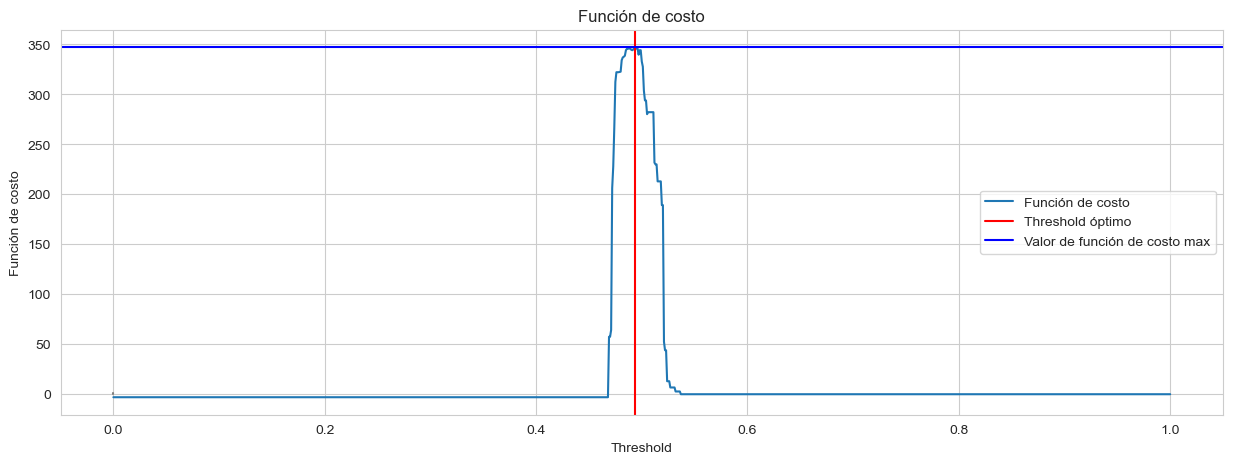

In [57]:
# Grafico curva de función de costo
sns.set_style('whitegrid')
plt.figure(figsize=(15,5))
plt.title("Función de costo")
plt.plot(df_thre["Threshold"],df_thre["cost_function"],label="Función de costo")

#plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.ylabel("Función de costo")
plt.xlabel("Threshold")
plt.axvline(threshold_max, c="r", label="Threshold óptimo")
plt.axhline(cost_function_max, c="b", label="Valor de función de costo max")
plt.legend()
plt.show()

In [58]:
# Threshold optimo
threshold_max

0.494

<a id="#4"></a> <br>
## 4. Evaluación del modelo

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [59]:
model_predict_proba_train = model.predict_proba(X_train)
model_pred_train = binarize(model_predict_proba_train, threshold = threshold_max)[:,1]

model_predict_proba_test = model.predict_proba(X_test)
model_pred_test = binarize(model_predict_proba_test, threshold = threshold_max)[:,1]

ftwo_train = fbeta_score(y_train, model_pred_train, beta = 2)
ftwo_test = fbeta_score(y_test ,model_pred_test, beta = 2)

fone_train = f1_score(y_train, model_pred_train)
fone_test = f1_score(y_test, model_pred_test)

accuracy_train = accuracy_score(y_train, model_pred_train)
accuracy_test = accuracy_score(y_test, model_pred_test)

ROC_train = roc_auc_score(y_train, model_pred_train)
ROC_test = roc_auc_score(y_test, model_pred_test)

recall_train = recall_score(y_train, model_pred_train)
recall_test = recall_score(y_test, model_pred_test)

precision_train = precision_score(y_train, model_pred_train)
precision_test = precision_score(y_test, model_pred_test)

In [60]:
df_metricas = pd.DataFrame({'Models': ['Light gbm'],
                       'F2 Score Train':  [ftwo_train],
                       'F2 Score Test': [ftwo_test],
                       'F1 Score Train':  [fone_train],
                       'F1 Score Test': [fone_test],                       
                       'Accuracy Score Train':  [accuracy_train],
                       'Accuracy Score Test': [accuracy_test],
                       'ROC AUC Score Train':  [ROC_train],
                       'ROC AUC Score Test': [ROC_test],
                       'Recall Score Train':  [recall_train],
                       'Recall Score Test': [recall_test],
                      "Precision Score Train" : [precision_train],
                      "Precision Score Test" : [precision_test]})
df_metricas

,Models,F2 Score Train,F2 Score Test,F1 Score Train,F1 Score Test,Accuracy Score Train,Accuracy Score Test,ROC AUC Score Train,ROC AUC Score Test,Recall Score Train,Recall Score Test,Precision Score Train,Precision Score Test
0,Light gbm,0.671936,0.665962,0.598481,0.592814,0.755122,0.751566,0.74734,0.742911,0.731816,0.725654,0.506244,0.501085


<a id="42"></a> <br>
### 4.2. Matriz de confusión

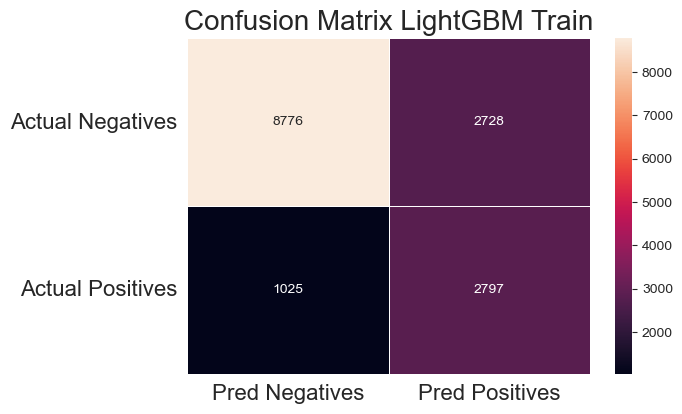

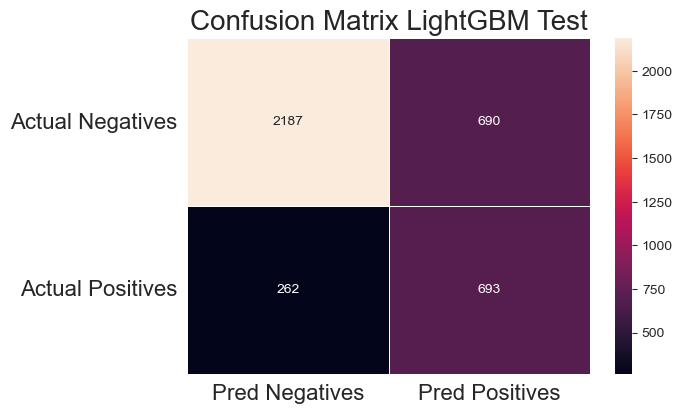

In [61]:
# Matriz de confusión para modelo seleccionado
conf_matrix = confusion_matrix(y_train, model_pred_train)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test, model_pred_test)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

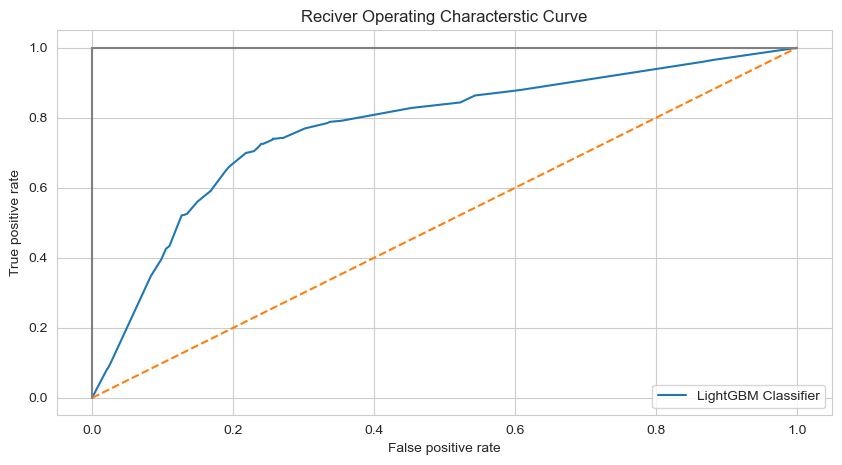

In [62]:
# Obtencion de predicciones para graficar curva ROC
probsdmodel = model.predict_proba(X_test)
predsdmodel = probsdmodel[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, predsdmodel)

0.5031352676236123


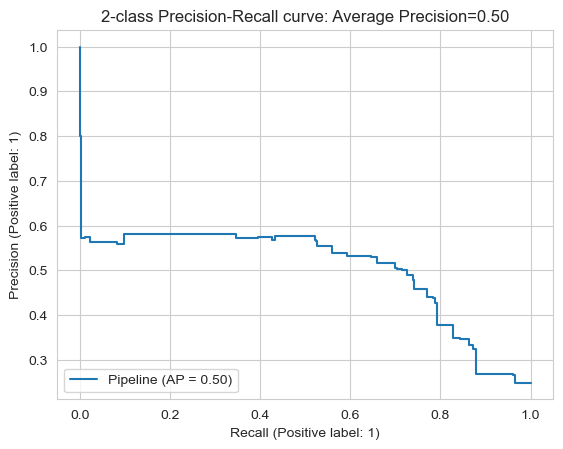

In [64]:

average_precision = average_precision_score(y_test, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));

<a id="45"></a> <br>
### 4.5. Feature importance

In [65]:
pipe.fit(X_train,y_train)
features_nominal = pipe_nominal["OneHotEncoder"].get_feature_names_out()
features_ordinal_and_numerical = pipe_ordinal_and_numerical["column_transformer"].get_feature_names_out()
features = np.concatenate((features_nominal, features_ordinal_and_numerical), axis=0)


importancia_features = pd.DataFrame(model["lgbm"].feature_importances_, index = features, columns=['importancia'])

importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)


importancia_features_sort = importancia_features_sort[importancia_features_sort.importancia != 0]

In [66]:
# Modificacion para poder diferenciar las variables con mascaras
importancia_features_sort['new col'] = importancia_features_sort.index
importancia_features_sort_splitted = importancia_features_sort['new col'].str.split('_', expand=True)
features_concat = pd.concat([importancia_features_sort_splitted,importancia_features_sort], axis=1)
features_concat = features_concat.rename(columns={0:'variable'})

# Obtencion de la suma de los valores por cada variable

x0_variable = features_concat[features_concat.variable == 'x0']
x0_importance = x0_variable['importancia'].sum()

x1_variable = features_concat[features_concat.variable == 'x1']
x1_importance = x1_variable['importancia'].sum()

x2_variable = features_concat[features_concat.variable == 'x2']
x2_importance = x2_variable['importancia'].sum()

x3_variable = features_concat[features_concat.variable == 'x3']
x3_importance = x3_variable['importancia'].sum()


# Creacion de diccionario con los valores obtenidos
dict_importance = {
        "importancia": [x0_importance, x1_importance, x2_importance, x3_importance ]
    }

dict_importance_DataFrame = pd.DataFrame(dict_importance, index = ["X0", "X1", "X2", "X3"])


# Mascaras para quedarnos solo con la columna de importacia
data_dropeado = features_concat[(features_concat.variable != 'x3') & (features_concat.variable != 'x0') & (features_concat.variable != 'x1') & (features_concat.variable != 'x2')]
data_dropeado_importance = data_dropeado.iloc[:, [6]]

# Unir el diccionario creado anteriormente
df_merged_importance = pd.concat([data_dropeado_importance, dict_importance_DataFrame], ignore_index=False, sort=False)


# Renombrar todos los indices para mayor claridad
df_new = df_merged_importance.rename(index={'standard_scaler__city_development_index': 'City development index',
                          'ordinal_encoder__company_size': 'Company size',
                          'ordinal_encoder__relevent_experience': 'Relevent experience',
                          'ordinal_encoder__education_level': 'Education level',
                          'ordinal_encoder__last_new_job': 'Last new job',
                          'ordinal_encoder__enrolled_university': 'Enrolled university',
                          'standard_scaler__training_hours': 'Training hours',
                          'ordinal_encoder__experience': 'Experience',
                          'X0': 'Gender',
                          'X1': 'Company Type',
                          'X2': 'Undergraduate Study',
                          'X3': 'City',
                         })
features_concat_last_version = df_new.rename(columns={"importancia":"Importance"})
importancia_features_sort=features_concat_last_version.sort_values('Importance', ascending=False)
importancia_features_sort

,Importance
Company size,256
City,156
Education level,117
City development index,86
Relevent experience,48
Last new job,32
Enrolled university,24
Undergraduate Study,1
Gender,0
Company Type,0


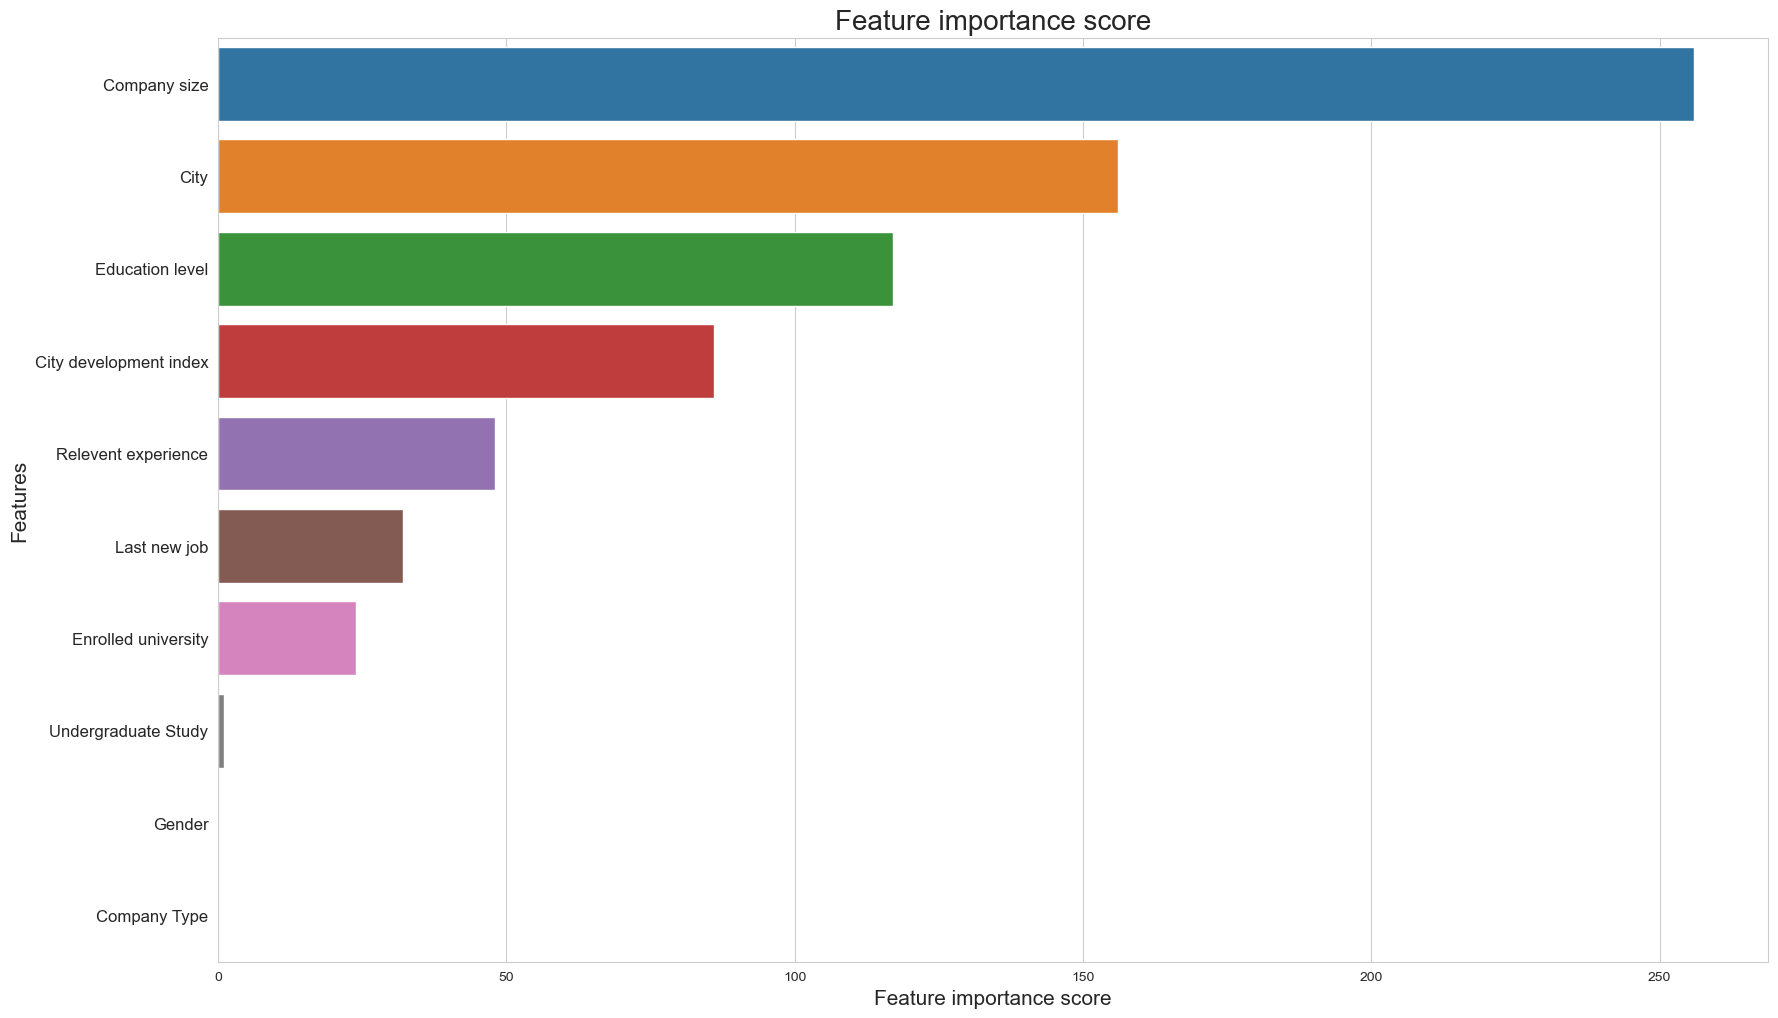

In [67]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(20, 12))
ax = sns.barplot(x=importancia_features_sort.Importance, y=importancia_features_sort.index, data=importancia_features_sort)
ax.set_title("Feature importance score",fontsize=20)
ax.set_yticklabels(importancia_features_sort.index, fontsize=12)
ax.set_xlabel("Feature importance score",fontsize=15)
ax.set_ylabel("Features",fontsize=15)
plt.show()

<a id="#5"></a> <br>
## 5. Exportación con Shelve

<a id="51"></a> <br>
### 5.1. Exportación con Shelve

In [68]:
lgbm = shelve.open('models_shelve/06_lgbm_model.db')

lgbm['modelo'] = model
lgbm['threshold'] = threshold_max
lgbm["cost_function"] = df_thre
lgbm["metricas"] = df_metricas

lgbm.close()